In [1]:
import wrds
import pandas as pd 
import numpy as np
from scipy.stats import norm

import matplotlib.pyplot as plt

In [2]:
wrds_user = 'eiger'
wrds_password = 'Nordwand2011'

conn = wrds.Connection(wrds_username=wrds_user, wrds_password=wrds_password)

Loading library list...
Done


In [3]:
df = conn.raw_sql("""select * from optionm.vsurfd1996 where secid in (108105)""",date_cols=['date'])
for year in range(1997,2024):
    
    df_new =conn.raw_sql("""select * from optionm.vsurfd"""+str(year)+""" where secid in (108105)""",date_cols=['date'])
    df = pd.concat([df,df_new])

In [4]:
df['date'] = pd.to_datetime(df['date'],format = '%Y-%m-&d')
df = df.dropna() #all errors are in IV

DATES = df.date.unique()

In [5]:
df = df.drop(labels=['secid','dispersion'],axis=1)
df.head(10)

,date,days,delta,impl_volatility,impl_strike,impl_premium,cp_flag
34,1996-01-04,30.0,-90.0,0.138704,652.5124,34.129130,P
35,1996-01-04,30.0,-85.0,0.137368,645.8368,28.195170,P
36,1996-01-04,30.0,-80.0,0.135625,640.5763,23.732180,P
37,1996-01-04,30.0,-75.0,0.132932,636.0494,20.037270,P
38,1996-01-04,30.0,-70.0,0.128539,631.9539,16.765150,P
39,1996-01-04,30.0,-65.0,0.124021,628.3651,14.014630,P
40,1996-01-04,30.0,-60.0,0.121505,625.2828,11.883240,P
41,1996-01-04,30.0,-55.0,0.120634,622.4753,10.174680,P
42,1996-01-04,30.0,-50.0,0.121280,619.7742,8.768702,P
43,1996-01-04,30.0,-45.0,0.123523,617.0321,7.589737,P


In [11]:
MAT = [30,60,91,182,273,365]

df_30 = df[df.days == 30]
df_60 = df[df.days == 60]
df_91 = df[df.days == 91]
df_182 = df[df.days == 182]
df_273 = df[df.days == 273]
df_365 = df[df.days == 365]

Get IR:

In [7]:
ir_df = conn.get_table(library='optionm', table='zerocd')
ir_df['date'] = pd.to_datetime(ir_df['date'],format = '%Y-%m-%d')

Verify the prices in the vol. surface data are in BS prices.

In [255]:
date = DATES[100]

#Get parameters
TTM = 30 #time to maturity
OPT = df_30.loc[(df_30['date']==date) & (df_30['cp_flag'] == 'C'),['impl_premium','impl_strike','delta','impl_volatility']]

In [256]:
IR = ir_df[ir_df['date'] == date]

Get IR for the relevant maturity, will need to linear interpolate for maturities that are not present in IR table.

In [257]:
ind_upr = None
for ind in IR.index:
    D = IR.loc[ind,'days']
    if D>TTM:
        ind_upr = ind
        ind_lwr = ind-1
        
        break
        
if ind_upr == IR.index[0]:
    r = IR.loc[ind_upr,'rate']

elif ind_upr == None:
    ind_fin = IR.index[-1]
    r = IR.loc[ind_fin,'rate']

else:
    r_upr = IR.loc[ind_upr,'rate']
    days_upr = IR.loc[ind_upr,'days']

    r_lwr = IR.loc[ind_lwr,'rate']
    days_lwr = IR.loc[ind_lwr,'days']

    r = r_lwr + (r_upr - r_lwr)*(TTM - days_lwr)/(days_upr - days_lwr)

print(r)

5.488469285714285


We can back out the moneyness from delta:

In [258]:
def GET_UND_PRICE(sigma,K,r,TTM,delta):
    d1 = norm.ppf(delta/100)
    T = TTM/365 #should this be changed to trading days??
    
    S = np.exp(d1*sigma*np.sqrt(T) - (r/100 - (sigma**2)/2)*T)*K
    
    return S

Applying the function to the OPT df above will return several values, one for each row, that should be equal.

In [259]:
OPT.apply(lambda x: GET_UND_PRICE(x.impl_volatility,x.impl_strike,r,TTM,x.delta),axis=1)

37451    672.010350
37452    672.010853
37453    672.023166
37454    672.045425
37455    672.077001
37456    672.119298
37457    672.170137
37458    672.224908
37459    672.283862
37460    672.350562
37461    672.429540
37462    672.525655
37463    672.640730
37464    672.770503
37465    672.918475
37466    673.096675
37467    673.273054
dtype: float64

Very close to eachother, take average as the underlying price.

In [260]:
S = OPT.apply(lambda x: GET_UND_PRICE(x.impl_volatility,x.impl_strike,r,TTM,x.delta),axis=1).mean()

In [261]:
def BS_PRICE(S,K,TTM,r,sigma):
    T = TTM/365
    d1 = (np.log(S/K) + (r/100 + (sigma**2)/2)*T)/(sigma*np.sqrt(T))
    d2 = d1 - sigma*np.sqrt(T)
    
    C = S*norm.cdf(d1) - K*np.exp(-r/100 * T)*norm.cdf(d2)
    return C

In [262]:
OPT['BS_PRICE'] = OPT.apply(lambda x: BS_PRICE(S,x.impl_strike,TTM,r,x.impl_volatility),axis=1)

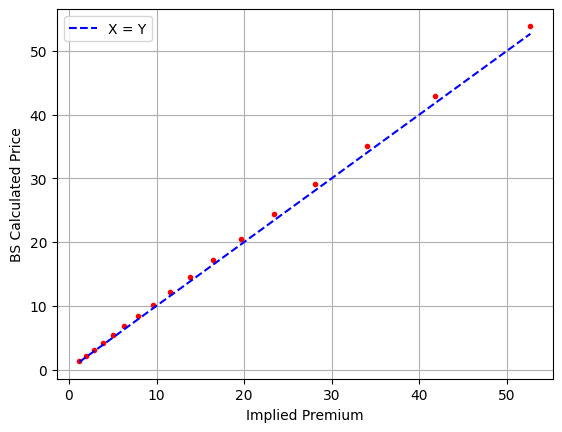

In [263]:
plt.plot(OPT.impl_premium, OPT.BS_PRICE,'.r')
plt.plot(OPT.impl_premium,OPT.impl_premium,'b--',label = 'X = Y')

plt.xlabel('Implied Premium')
plt.ylabel('BS Calculated Price')
plt.grid()
plt.legend()
plt.show()

Seems to be a small bias that is larger for the greater smaller strikes. This difference is likely the result of not accounting for dividends in the index. The implied price might account for it which would result in the BS call price to be slightly higher, if we checked the puts - they should be slightly lower. The lower strikes are more in the money - higher delta exposure - more affected by the dividends.

Despite this, it would be safe to say that the prices that are implied here are just the BS price based on the implied volatility.

### VIX term structure

Now we get the term structure by calculating the VIX at the relevant time to expiry (in days).

To speed this up I will create a new dataframe, each row will become a single date. The columns will then become the strikes and prices labelled by the delta, the IR for that term and the forward price. The VIX function can then be apllied to the df in a much quicker manner.

In [8]:
RATES = pd.DataFrame({'DATE':DATES,'30':None,'60':None,'91':None,'182':None,'273':None,'365':None})
IR_DATES = ir_df.date.unique()

In [9]:
def GET_IR(DATA,term):
    ind_upr = None
    for ind in DATA.index:
        DAYS = DATA.loc[ind,'days']
        if DAYS>term:
            ind_upr = ind
            ind_lwr = ind-1

            break

    if ind_upr == DATA.index[0]:
        r = DATA.loc[ind_upr,'rate']

    elif ind_upr == None:
        ind_fin = DATA.index[-1]
        r = DATA.loc[ind_fin,'rate']

    else:
        r_upr = DATA.loc[ind_upr,'rate']
        days_upr = DATA.loc[ind_upr,'days']

        r_lwr = DATA.loc[ind_lwr,'rate']
        days_lwr = DATA.loc[ind_lwr,'days']

        r = r_lwr + (r_upr - r_lwr)*(term - days_lwr)/(days_upr - days_lwr)
    
    return r

In [12]:
for ind in range(0,len(RATES)):
    date = DATES[ind]
    SUB = ir_df[ir_df.date == date]
    if len(SUB) == 0:
        RATES.iloc[ind,1:] = RATES.iloc[ind-1,1:] #if date doesn't have IR, use previous day
    else:
        for term in MAT:
            RATES.loc[RATES['DATE']==date,str(term)] = GET_IR(SUB,term)
    next

The forward prices table will not be the best since they don't have all the expirations we need. It would be better to use the forward price implied by the option prices.

$$ F = K + e^{rT} (C-P) $$

In [13]:
class OPT_DATA:
    
    def __init__(self,term):
        self.RAW = df[df.days == term]
        self.table = pd.DataFrame({'DATE':DATES,'K0':None,
                      'K-10':None,'K-15':None,'K-20':None,'K-25':None,'K-30':None,'K-35':None,'K-40':None,'K-45':None,'K-50':None,
                      'P-10':None,'P-15':None,'P-20':None,'P-25':None,'P-30':None,'P-35':None,'P-40':None,'P-45':None,'P-50':None,
                      'K10':None,'K15':None,'K20':None,'K25':None,'K30':None,'K35':None,'K40':None,'K45':None,'K50':None,
                      'C10':None,'C15':None,'C20':None,'C25':None,'C30':None,'C35':None,'C40':None,'C45':None,'C50':None,
                      'F':None,'R':None})
        
        DELTAS = [10,15,20,25,30,35,40,45,50]
        
        for delta in DELTAS:
            self.table.loc[:,'K'+str(delta)] = self.RAW.loc[self.RAW['delta'] == delta,'impl_strike'].values
            self.table.loc[:,'K-'+str(delta)] = self.RAW.loc[self.RAW['delta'] == -delta,'impl_strike'].values

            self.table.loc[:,'C'+str(delta)] = self.RAW.loc[self.RAW['delta'] == delta,'impl_premium'].values
            self.table.loc[:,'P-'+str(delta)] = self.RAW.loc[self.RAW['delta'] == -delta,'impl_premium'].values
        
        self.table['K0'] = 0.5*(self.table['K50'] + self.table['K-50']) #the two strikes should be equal
        self.table['R'] = RATES[str(term)].values
        
        self.table['F'] = self.table['K0'] + np.exp(1)**(self.table['R']/100 * term/365) * (self.table['C50'] - self.table['P-50'])

In [14]:
def GET_VIX(K_list,Px_list,K0,TTM,R,F):
    SUM = 0
    n = len(K_list)
    T = TTM/365
    
    for i in range(0,n):
        if i == 0:
            delta_K = K_list[1] - K_list[0]
        elif i == (n-1):
            delta_K = K_list[n-1] - K_list[n-2]
        else:
            delta_K = 0.5*(K_list[i+1] - K_list[i-1])
        
        K = K_list[i]
        Q = Px_list[i]
        
        SUM += (2/T) * delta_K/(K**2) * np.exp(R/100 * T) * Q
        
    VIX = SUM - (1/T) * (F/K0 - 1)**2
    
    return VIX

In [15]:
DF_30 = OPT_DATA(30)

In [16]:
P_K_list = DF_30.table.columns[2:11]
P_list= DF_30.table.columns[11:20]

C_K_list = DF_30.table.columns[20:29]
C_list= DF_30.table.columns[29:38]

K_list = list(P_K_list)+ list(C_K_list)[::-1]
Q_list = list(P_list)+ list(C_list)[::-1]

In [466]:
VIX_30 = DF_30.table.apply(lambda x: GET_VIX(x[K_list],x[Q_list],x['K0'],30,x['R'],x['F']),axis=1)

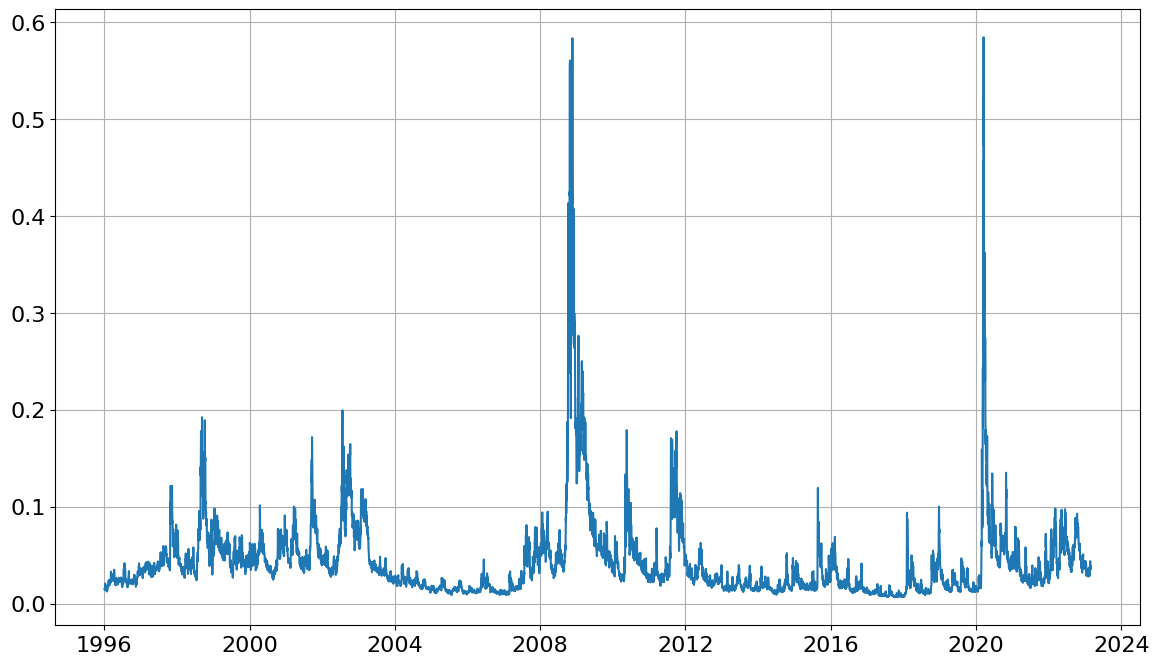

In [472]:
plt.figure(figsize=(14,8))
plt.rcParams.update({'font.size': 16})
plt.plot(DF_30.table.DATE,VIX_30)
plt.grid()

Now get it for each of terms and collect in one DataFrame:

In [473]:
MAT

[30, 60, 91, 182, 273, 365]

In [17]:
DF_1 = OPT_DATA(30)
VIX_1 = DF_1.table.apply(lambda x: GET_VIX(x[K_list],x[Q_list],x['K0'],30,x['R'],x['F']),axis=1)

DF_2 = OPT_DATA(60)
VIX_2 = DF_2.table.apply(lambda x: GET_VIX(x[K_list],x[Q_list],x['K0'],60,x['R'],x['F']),axis=1)

DF_3 = OPT_DATA(91)
VIX_3 = DF_3.table.apply(lambda x: GET_VIX(x[K_list],x[Q_list],x['K0'],91,x['R'],x['F']),axis=1)

DF_6 = OPT_DATA(182)
VIX_6 = DF_6.table.apply(lambda x: GET_VIX(x[K_list],x[Q_list],x['K0'],182,x['R'],x['F']),axis=1)

DF_9 = OPT_DATA(273)
VIX_9 = DF_9.table.apply(lambda x: GET_VIX(x[K_list],x[Q_list],x['K0'],273,x['R'],x['F']),axis=1)

DF_12 = OPT_DATA(365)
VIX_12 = DF_12.table.apply(lambda x: GET_VIX(x[K_list],x[Q_list],x['K0'],365,x['R'],x['F']),axis=1)

In [18]:
VIX_TS = pd.DataFrame({'Date':DATES,'1 month':VIX_1,'2 month':VIX_2,'3 month':VIX_3,'6 month':VIX_6,'9 month':VIX_9,'12 month':VIX_12})

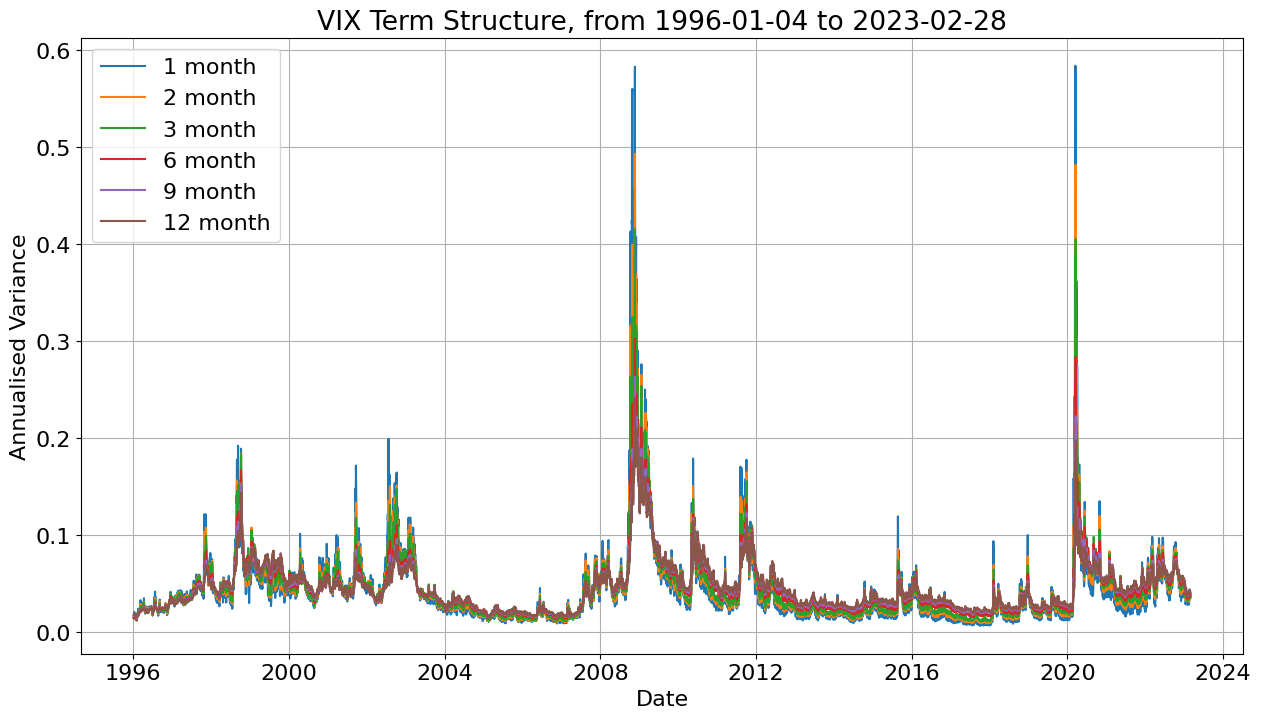

In [19]:
plt.figure(figsize=(15,8))
plt.rcParams.update({'font.size': 16})

for c_ind in range(1,7):
    LAB = VIX_TS.columns[c_ind]
    Y = VIX_TS.iloc[:,c_ind]
    
    plt.plot(DATES,Y,label = LAB)
    
    
plt.legend()
plt.ylabel('Annualised Variance')
plt.xlabel('Date')
plt.title('VIX Term Structure, from ' + str(min(DATES).date()) + ' to ' + str(max(DATES).date()))
plt.grid()
plt.show()

In [21]:
VIX_TS.to_csv('VIX_TS.csv')